# To compare with Karyn work (v202111)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import os
import datetime as dt
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import cmocean
import json
import f90nml
from collections import OrderedDict
from scipy.stats.mstats import gmean
import xarray as xr
import netCDF4 as nc
import gsw
#import mocsy
import netCDF4 as nc

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display



%matplotlib inline

In [3]:
f=xr.open_dataset('/results2/SalishSea/nowcast-green.202111/06apr21/SalishSea_1d_20210406_20210406_chem_T.nc')

### Puget Sound data from https://www.ncei.noaa.gov/data/oceans/ncei/ocads/metadata/0238424.html
Cite: Alin, Simone R.; Newton, Jan; Greeley, Dana; Curry, Beth; Herndon, Julian; Kozyr, Alex; Feely, Richard A. (2021). A compiled data product of profile, discrete biogeochemical measurements from 35 individual cruise datasets collected from a variety of ships in the southern Salish Sea and northern California Current System (Washington state marine waters) from 2008-02-04 to 2018-10-19 (NCEI Accession 0238424). [indicate subset used]. NOAA National Centers for Environmental Information. Dataset. https://doi.org/10.25921/zgk5-ep63. Accessed [date].

In [4]:
PS=pd.read_csv('/ocean/ksuchy/MOAD/analysis-karyn/notebooks/Evaluations/SalishCruise_dataProduct_2008to2018_09202023_allData.csv') ## Data from OCADS dataset

In [5]:
PS.rename(columns={'LONGITUDE_DEC':'Lon','LATITUDE_DEC':'Lat','DATE_UTC':'Date','TIME_UTC':'Time',\
                   'CRUISE_ID':'Cruise','CTDPRS_DBAR':'Z',\
                   'CTDTMP_DEG_C_ITS90':'Temp (degC)','STATION_NO':'Name','CTDSAL_PSS78':'Sal (PSS)'},inplace=True) 

In [6]:
PS=PS[~(PS['Lon'] < -124) & (PS['Lat'] < 50.0)] 

In [7]:
PS['Sal (g kg-1)']=gsw.conversions.SA_from_SP(PS['Sal (PSS)'],PS['Z'], PS['Lon'], PS['Lat']) ##absolute salinity
PS['Temp (CT degC)']=gsw.CT_from_t(PS['Sal (g kg-1)'], PS['Temp (degC)'], PS['Z']) ##conservative temp
PS_rho = gsw.density.rho((PS['Sal (g kg-1)']),(PS['Temp (CT degC)']),(PS['Z']))

In [8]:
PS['DO (uM)']= PS['RECOMMENDED_OXYGEN_UMOL_KG'] *(PS_rho/1000)
PS['NO3 (uM)']= PS['NITRATE_UMOL_KG'] *(PS_rho/1000)
PS['NO2 (uM)']= PS['NITRITE_UMOL_KG'] *(PS_rho/1000)
PS['NH4 (uM)']= PS['AMMONIUM_UMOL_KG'] *(PS_rho/1000)
PS['PO4 (uM)']= PS['PHOSPHATE_UMOL_KG'] *(PS_rho/1000)
PS['SIO4 (uM)']= PS['SILICATE_UMOL_KG'] *(PS_rho/1000)
PS['TA (uM)']= PS['TA_UMOL_KG'] *(PS_rho/1000)
PS['DIC (uM)']= PS['DIC_UMOL_KG'] *(PS_rho/1000)

In [9]:
 # Retain only selected variables following Parker MacCready https://github.com/parkermac/LO/blob/main/obs/nceiCoastal/process_data.py
cols = ['Cruise','Date', 'Time', 'Lat', 'Lon', 'PATH', 'Z',
        'Temp (degC)','Temp (CT degC)', 'Sal (g kg-1)','Sal (PSS)' ,'DO (uM)',
        'NO3 (uM)', 'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)',
        'TA (uM)', 'DIC (uM)','TA_FLAG_W', 'DIC_FLAG_W']
this_cols = [item for item in cols if item in PS.columns]
PS = PS[this_cols]

In [10]:
PS

,Cruise,Date,Time,Lat,Lon,Z,Temp (degC),Temp (CT degC),Sal (g kg-1),Sal (PSS),DO (uM),NO3 (uM),NO2 (uM),NH4 (uM),PO4 (uM),TA (uM),DIC (uM),TA_FLAG_W,DIC_FLAG_W
35,AQ201610,2016-10-25,6:09:55,48.2240,-123.4811,141.608,8.3447,8.349652,33.391446,33.2297,106.035872,29.788587,0.287416,0.000000,2.545682,2285.776176,2263.398809,2,2
36,AQ201610,2016-10-25,6:11:19,48.2241,-123.4808,110.587,8.7967,8.812697,32.943459,32.7846,126.599120,28.787450,0.287259,0.000000,2.492997,2264.421219,2234.874585,2,2
37,AQ201610,2016-10-25,6:12:26,48.2242,-123.4806,80.753,9.3383,9.367434,32.420453,32.2648,149.795861,27.324159,0.307589,0.112783,2.419700,2235.146995,2199.159078,2,2
38,AQ201610,2016-10-25,6:13:34,48.2243,-123.4804,50.157,9.8490,9.891354,31.944572,31.7917,180.040763,25.463933,0.348400,0.399635,2.336329,2210.494783,2163.460798,2,2
39,AQ201610,2016-10-25,6:14:23,48.2243,-123.4802,30.641,9.9635,10.010329,31.838209,31.6858,183.798087,25.151856,0.358580,0.399561,2.335895,2203.528012,2154.965975,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7478,SH1604,2016-03-18,21:30:02,48.2472,-123.9837,29.953,9.1606,9.224768,30.627549,30.4809,260.940853,19.399094,0.286636,0.000000,1.678866,-1022.675213,-1022.675213,9,9
7479,SH1604,2016-03-18,21:30:37,48.2473,-123.9838,20.745,9.1351,9.203877,30.398465,30.2525,271.836961,17.655074,0.286575,0.173992,1.576163,2121.781639,2025.676629,2,2
7480,SH1604,2016-03-18,21:31:15,48.2473,-123.9840,11.556,9.1476,9.218510,30.330848,30.1851,287.571472,16.722128,0.276314,0.000000,1.524845,-1022.362634,-1022.362634,9,9
7481,SH1604,2016-03-18,21:31:53,48.2475,-123.9842,5.631,9.1844,9.256224,30.325521,30.1796,289.300818,16.660125,0.307005,0.102335,1.514557,-1022.325848,-1022.325848,9,9


In [11]:
## Code in this cell is based on Tereza's Dataset_dfmaker.ipynb notebook to keep everything consistent. Check with Debby and Susan about using DIC/TA masks and quality flagged. Will need to quality control Puget Sound data too?


PS_mask = (((PS['DIC_FLAG_W']==2) | (PS['DIC_FLAG_W']==6)) & \
        ((PS['TA_FLAG_W']==2) | (PS['TA_FLAG_W']==6)) & \
        (PS['DIC (uM)'] > 0) & (PS['TA (uM)'] >0))
print(np.shape(PS['DIC (uM)'][PS_mask]))
PS['DIC (uM)']=PS['DIC (uM)'][PS_mask]
PS['TA (uM)']=PS['TA (uM)'][PS_mask]

(3812,)


In [12]:
SoG=pd.read_csv('/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/PI_CARBON_PAPER/MAIN_ANALYSIS/KEY_MODEVAL/Datasets/combined_fromdf.csv')
## data from Tereza Jarnikova's compiled dataset for Canadian waters of Salish Sea

In [13]:
SoG['Year']=SoG['crid'].astype(str).str[:4]
SoG['mon']=SoG['mon'].astype(str).str[:1]
SoG['day']=SoG['day'].astype(str).str[:1]

In [14]:
### Combine three columns of date information into a single time column
SoG['time'] = SoG.apply(lambda r: dt.datetime.strptime(f"{r['Year']} {r['mon']} {r['day']} {0}:{0}:{0}", '%Y %m %d %H:%M:%S'), axis=1)

In [15]:
SoG.rename(columns={'lat':'Lat','lon':'Lon','time':'dtUTC','P':'Z',\
                   'T':'Temp (degC)','S':'Sal (PSS)'},inplace=True)

In [16]:
SoG['Sal (g kg-1)']=gsw.conversions.SA_from_SP(SoG['Sal (PSS)'],SoG['Z'], SoG['Lon'], SoG['Lat']) ##absolute salinity
SoG['Temp (CT degC)']=gsw.CT_from_t(SoG['Sal (g kg-1)'], SoG['Temp (degC)'], SoG['Z']) ##conservative temp
SoG_rho = gsw.density.rho((SoG['Sal (g kg-1)']),(SoG['Temp (CT degC)']),(SoG['Z'])) ## check to make sure this is the correct density formula (from teos-10)

## used the same equation as Parkers process_data.py file
SoG['DIC (uM)']=SoG['dic']*(SoG_rho/1000)
SoG['TA (uM)']=SoG['alk']*(SoG_rho/1000)

In [17]:
## Code in this cell is based on Tereza's Dataset_dfmaker.ipynb notebook to keep everything consistent. Check with Debby and Susan about using DIC/TA masks and quality flagged. Will need to quality control Puget Sound data too?

SoG_mask = (((SoG['dic_qf']==2) | (SoG['dic_qf']==6)) & \
        ((SoG['alk_qf']==2) | (SoG['alk_qf']==6)) & \
        (SoG['dic'] > 0) & (SoG['alk'] >0))
SoG['DIC (uM)']=SoG['dic'][SoG_mask]
SoG['TA (uM)']=SoG['alk'][SoG_mask]
print(np.shape(SoG['dic'][SoG_mask]))

(572,)


In [18]:
PS.rename(columns={'Date':'dtUTC','TA_FLAG_W':'TA_FLAG','DIC_FLAG_W':'DIC_FLAG'},inplace=True)
SoG.rename(columns={'alk_qf':'TA_FLAG','dic_qf':'DIC_FLAG'},inplace=True)

In [19]:
PS['dtUTC']=pd.to_datetime(PS.dtUTC).dt.tz_localize(None)

In [20]:
## create data df by combining Becca and Tereza's datasets
dataa=pd.concat([PS, SoG], axis=0, join='outer')

In [21]:

dataa['dtUTC']=pd.to_datetime(dataa['dtUTC']) 

In [22]:
dataa['Year']=[ii.year for ii in dataa['dtUTC']]
dataa['Month']=[ii.month for ii in dataa['dtUTC']]

In [23]:
dataa['YMO']=pd.to_datetime(dataa[['Year', 'Month']].assign(DAY=1))

In [24]:
data=dataa[(dataa['Year'] >= 2015) & (dataa['Year'] <= 2018)] 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


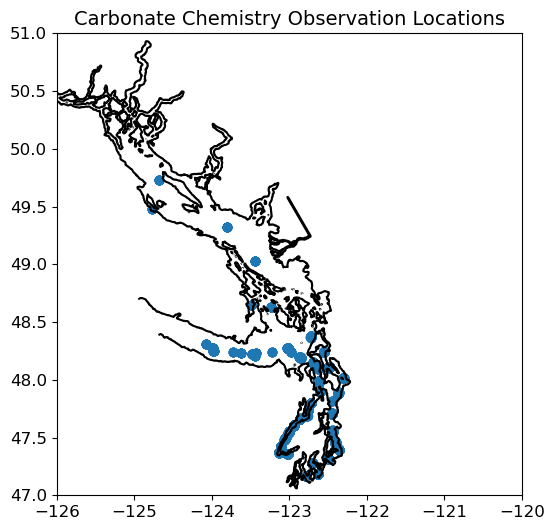

In [25]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_202108.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('teal','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue','lightblue')
ax.scatter(data['Lon'], data['Lat'],marker='o') #color = colors[ind]
ax.set_ylim(47,51)
plt.yticks(fontsize=12)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-126, -120)
plt.xticks(fontsize=12);
ax.set_title('Carbonate Chemistry Observation Locations',fontsize=14);
ax.legend(frameon=False)

In [26]:
data.dtUTC.min()

Timestamp('2015-04-01 00:00:00')

In [27]:
data.dtUTC.max()

Timestamp('2018-10-19 00:00:00')

In [28]:
data.to_csv('/ocean/atall/MOAD/Obs/SalishCruise_dataProduct_2015to2018_fromKaryn.csv') # /ocean/ksuchy/MOAD/analysis-karyn/notebooks/Evaluations/SalishCruise_dataProduct_2008to2018_09202023_allData.csv